# LANL Earthquakes Experiment
# Spectrogram Analysis

#### Main contents:

- Display data
- Spectrograms: try several configurations
- Scaling: choose scale to map from spectrograms into colors 0-255
- Generate spectrograms and save to disk

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from pathlib import Path
import pickle as pkl
from time import time
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
import os, sys
from warnings import warn
import itertools
from PIL import Image

## Load and show data

In [3]:
BASE = Path('../Data')
n = int(150e3)

df1 = pd.read_csv(BASE/'train.csv', nrows=n, skiprows=None,
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df1.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

df2 = pd.read_csv(BASE/'train.csv', nrows=n, skiprows=range(1,int(2.2e6)),
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df2.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

df_peak = pd.read_csv(BASE/'train.csv', nrows=n, skiprows=range(1,int(4.4e6)), # hop ~176
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_peak.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

In [4]:
print(df1.head())
print(df1.info())
print(df1.describe())

   signal  quaketime
0      12     1.4691
1       6     1.4691
2       8     1.4691
3       5     1.4691
4       8     1.4691
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
signal       150000 non-null int16
quaketime    150000 non-null float64
dtypes: float64(1), int16(1)
memory usage: 1.4 MB
None
              signal      quaketime
count  150000.000000  150000.000000
mean        4.884113       1.450182
std         5.101106       0.011248
min       -98.000000       1.430797
25%         3.000000       1.440398
50%         5.000000       1.449999
75%         7.000000       1.459599
max       104.000000       1.469100


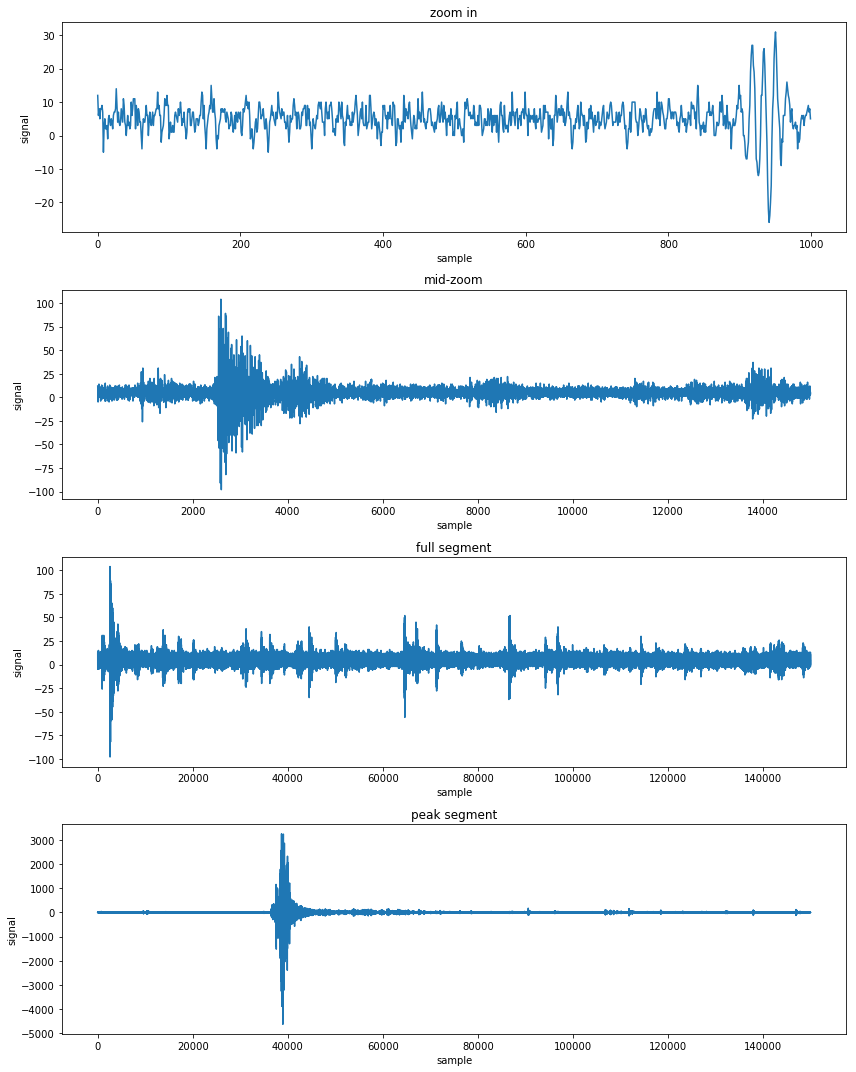

In [5]:
fig,axs = plt.subplots(4,1, figsize=(12,15))
axs[0].plot(df1.signal.head(1000))
axs[1].plot(df1.signal.head(15000))
axs[2].plot(df1.signal.head(150000))
axs[3].plot(df_peak.signal)
for i,ax in enumerate(axs):
    ax.set_title(('zoom in','mid-zoom','full segment','peak segment')[i])
    ax.set_xlabel('sample')
    ax.set_ylabel('signal')
plt.tight_layout()

## Batch-aligned FFT
There're suspected discontinuities in sampling times every 4096 samples ("batches"), so we found these discontinuities and compare batches FFTs with & without alignment to the discontinuity.

It looks like the discontinuity does not noticably ruin the FFT, at least in the first 150K-samples segment, so we gave up on this.

In [6]:
# def get_batches(df, verbose=True):
#     dt = np.median(np.diff(-df.quaketime))
#     transitions = np.where(np.logicaddl_or(
#         np.diff(-df.quaketime)>10*dt, np.diff(-df.quaketime)<-10*dt) )[0] + 1
#     transitions = np.concatenate(([0], transitions, [len(df)]))
#     if verbose:
#         print('Distribution of blocks lengths:')
#         l = [tf-ti for ti,tf in zip(transitions[:-1],transitions[1:])]
#         print(tuple((g[0], len(list(g[1]))) for g in itertools.groupby(sorted(l))))
#         print(f'Valid blocks (4096 samples):\t' +
#               f'{np.sum(np.diff(transitions)==4096):.0f}/{len(l):d}')
#     return transitions

# transitions = get_batches(df)
# transitions = get_batches(df_peak)

## Spectrogram research: how to get best signal to spectrogram conversion?

In [7]:
seg_len = int(150e3)
window_len = 4096
spec_hop_len = window_len // 4
n_windows = seg_len // window_len
n_spec_hops = (seg_len-window_len+spec_hop_len) // spec_hop_len

In [39]:
def create_spectrogram(signal, filt=(501,4,50), log=True, verbose=2):
    
    if verbose>=2:
        fig, axs = plt.subplots(1,3, figsize=(15,6))
        axs[0].plot(signal)
        axs[0].set_title('Segment Signal')
        
    ffts = []
    for hop in range(n_spec_hops):
        if verbose>=3:
            print(f'{hop}/{n_spec_hops}')
        f = np.abs(np.fft.rfft(signal[hop*spec_hop_len:hop*spec_hop_len+window_len], norm="ortho"))
        if log:
            f = np.log(1+f)
        if filt is not None:
            cuts = np.concatenate((np.arange(1,filt[0],filt[1]),np.arange(filt[0],len(f),filt[2])[:-1]))
            sp = np.split(f,cuts)
            f = [np.mean(ss) for ss in sp]
        ffts.append(f)
        
    spec = np.array(ffts)
    
    if verbose>=2:
        f = spec[0,:]
        if filt is not None:
            unique, counts = np.unique([len(ss) for ss in sp], return_counts=True)
            print(dict(zip(unique, counts)))
        axs[1].plot(f)
        axs[1].set_title("Last Window's FFT")
        
    if verbose >= 1:
        print(spec.shape)
        if verbose >= 2:
            ax = axs[2]
        else:
            fig,ax = plt.subplots(1,1)
        ax.imshow(spec)
        ax.set_title('Spectrogram')
        ax.set_xlabel('Frequency Group')
        ax.set_ylabel('Time [samples]')
        
    return spec

{1: 1, 4: 125, 50: 29, 98: 1}
(143, 156)
(143, 2049)
{1: 1, 4: 125, 50: 29, 98: 1}
(143, 156)


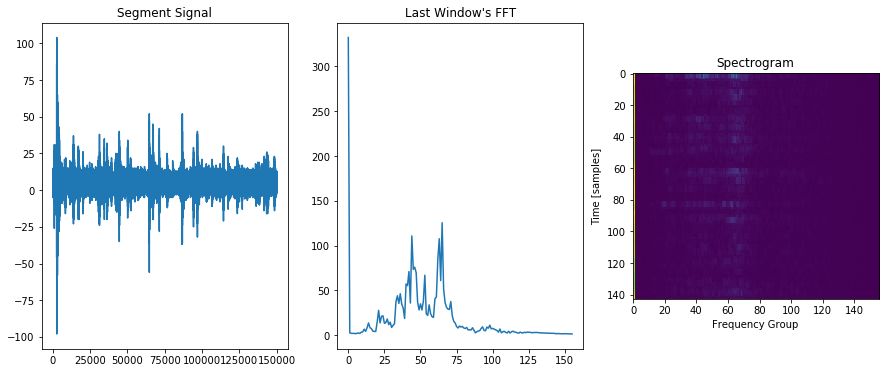

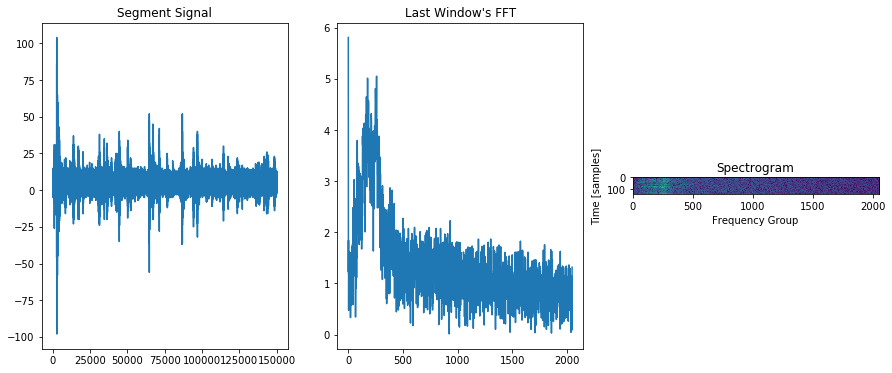

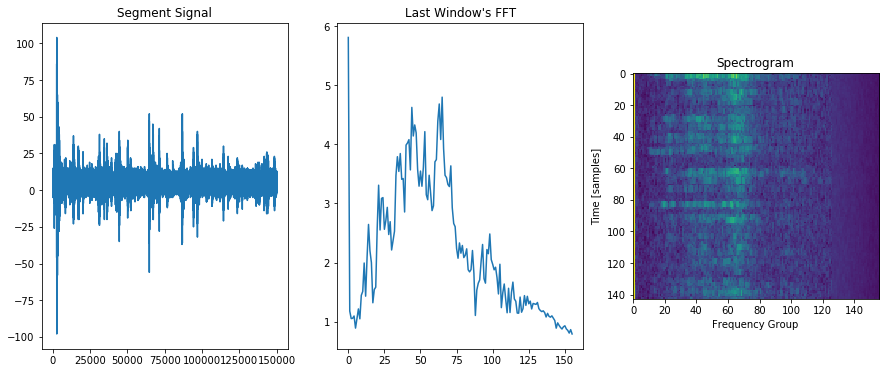

In [40]:
s = create_spectrogram(df1.signal, filt=(501,4,50), log=False)
s = create_spectrogram(df1.signal, filt=None, log=True)
s = create_spectrogram(df1.signal, filt=(501,4,50), log=True)

{1: 1, 4: 125, 50: 29, 98: 1}
(143, 156)


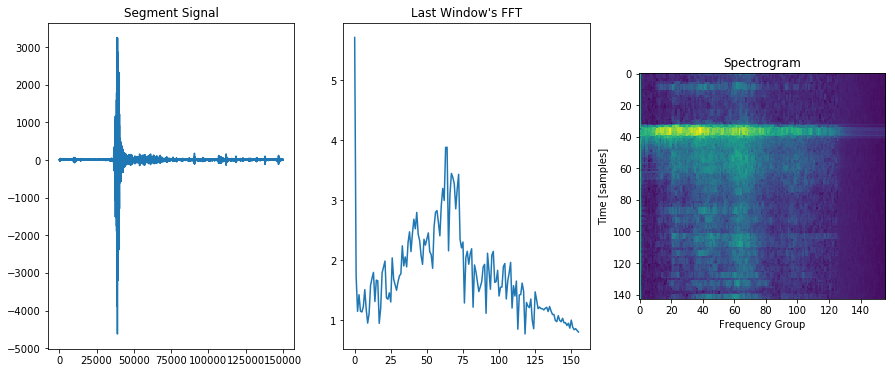

In [41]:
s = create_spectrogram(df_peak.signal, filt=(501,4,50), log=True)

## Scale research
#### since spectrograms need to be saved as images (with scale 0-255), how should we scale them?

In [11]:
n = int(10e6)

df = pd.read_csv(BASE/'train.csv', nrows=n, skiprows=None,
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

print(df.shape)

(10000000, 2)


The first quake is included in the loaded data.

The loaded signal reaches a pre-quake peak of ~3000, which is similar enough to the high peaks of the whole signal (I think ~4500).

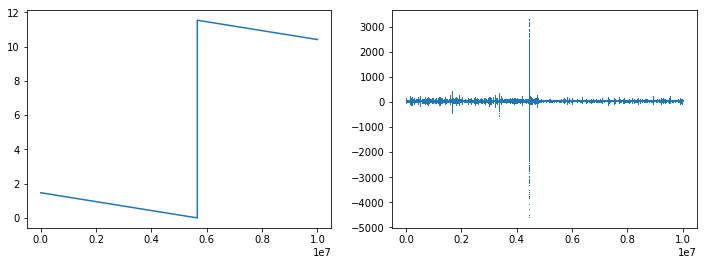

In [12]:
fig,axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(df.quaketime)
axs[1].plot(df.signal, ',')

The signal has very inconvenient distribution.

Text(0, 0.5, 'Signal Value')

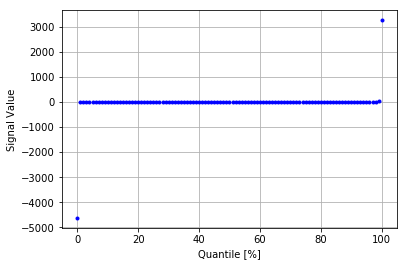

In [13]:
plt.plot(np.arange(0,101),np.quantile(df.signal, np.arange(0,101)/100),'b.')
plt.grid()
plt.xlabel('Quantile [%]')
plt.ylabel('Signal Value')

However, the log-scaled spectrograms seem to have quite convenient distribution.

In [14]:
n_all = int(10e6)
segs_to_read = 100
seg_len = int(150e3)
hop_len = int(25e3)
n_hops = n_all // hop_len
hops_to_read = int(segs_to_read * seg_len/hop_len)

S = []
smin = []
smax = []
for i in tqdm_notebook(range(n_hops)):
    if i % hops_to_read == 0:
        tmp = pd.read_csv(BASE/'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32},
                          nrows=seg_len*(segs_to_read+1), skiprows=range(1,1+i*hop_len))
        tmp.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)
    s = create_spectrogram(tmp[(i%hops_to_read)*hop_len:(i%hops_to_read)*hop_len+seg_len].signal, verbose=0)
    S.extend(s.flatten())
    smin.append(np.min(s))
    smax.append(np.max(s))

print(len(S))
print(np.min(S))
print(np.max(S))


8923200
0.257034098254897
8.738353744461907


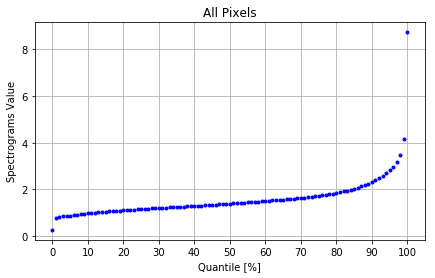

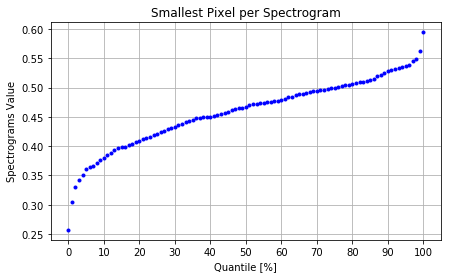

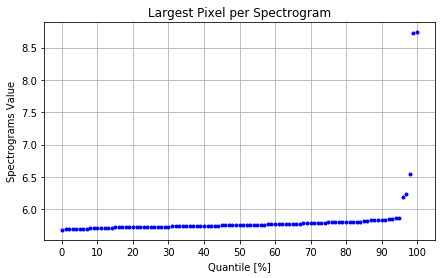

In [15]:
titles = ('All Pixels','Smallest Pixel per Spectrogram','Largest Pixel per Spectrogram')

for pixels, tit in zip((S,smin,smax),titles):
    q = np.quantile(pixels, np.arange(0,101)/100)

    plt.figure(figsize=(7,4))
    plt.plot(np.arange(0,101),q,'b.')
    plt.xticks(list(np.arange(0,101,10)))
    #plt.yticks(list(np.arange(0,9.5,0.5)))
    plt.title(tit)
    plt.grid()
    plt.xlabel('Quantile [%]')
    plt.ylabel('Spectrograms Value')

In order to have better focus on interesting values, we'll map the scale of the spectrograms linearly such that (0.25,6) -> (0,255)  (thus losing any information below 0.25 or beyond 6).
This range keeps the full scale of most of the spectrograms.

In [16]:
convert_colors = lambda x: np.array(np.minimum(np.maximum((x-0.25) * 255 / (6-0.25), 0), 255), dtype=np.uint8)

In [17]:
# # See mapped colors of all pixels quantiles:
# q = np.quantile(S, np.arange(0,101)/100)
# tmp = pd.DataFrame({'quantile':list(range(101)),'s':q, 'color':convert_colors(q)})
# with pd.option_context('display.max_rows', None): print(tmp)

## Generate spectrograms data

In [46]:
BASE = Path('../Data')
TRAIN = BASE/'train_spec4'
DEMO = False

if DEMO:
    n_all = int(1e6)
    segs_to_read = 100
else:
    n_all = 629145480 # df_full.shape[0]
    segs_to_read = 1050
seg_len = int(150e3)
hop_len = int(25e3) # try even 10e3?
n_hops = n_all // hop_len - (seg_len//hop_len-1)
hops_to_read = int(segs_to_read * seg_len/hop_len)

Read train data in 4 chunks of 1K segments;
save each segment's spectrogram (as png file);
and keep a table of segments and their quaketimes:

In [44]:
def save_spec(df, seg_index, meta, class_limits=(0,1,2,3,4,5,6,7,8,10,12,99), base_path=TRAIN):
    
    tf = df.quaketime.values[-1]
    cls = np.where([a<=tf<b for a,b in zip(class_limits[:-1],class_limits[1:])])[0][0]
    cls_nm = '-'.join((f'{class_limits[cls]:02d}',f'{class_limits[cls+1]:02d}'))
    fname = str(seg_index) + '_' + cls_nm + '.png'
    
    s = create_spectrogram(df.signal, verbose=0)
    s = convert_colors(s)
    s = np.repeat(s[:, :, np.newaxis], 3, axis=2)
    im = Image.fromarray(s)
    im.save(TRAIN/fname)
    
    meta.loc[seg_index] = [fname, tf, cls_nm, np.mean(s), np.var(s)]
    
    return s

,filename,time,class,mean,var
0,0_01-02.png,1.430797,01-02,58.650708,813.802417
1,1_01-02.png,1.424497,01-02,58.753048,839.883026
2,2_01-02.png,1.418096,01-02,59.066344,856.063018
3,3_01-02.png,1.411696,01-02,60.208625,929.984717
4,4_01-02.png,1.404200,01-02,59.634571,903.471356


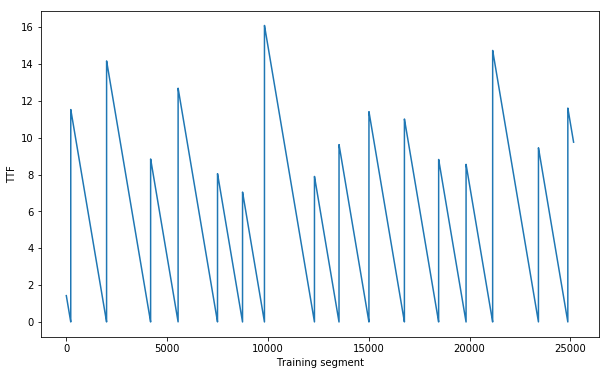

In [50]:
GENERATE_SPECTS = False

if GENERATE_SPECTS:
    meta = pd.DataFrame(columns=('filename','time','class','mean','var'))
    for i in tqdm_notebook(range(n_hops)):
        if i % hops_to_read == 0:
            tmp = pd.read_csv(BASE/'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32},
                              nrows=seg_len*(segs_to_read+1), skiprows=range(1,1+i*hop_len))
            tmp.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)
        s = save_spec(tmp[(i%hops_to_read)*hop_len:(i%hops_to_read)*hop_len+seg_len], i, meta)

    meta.to_csv(TRAIN/'train_spec_meta.csv', index=False)
else:
    meta = pd.read_csv(TRAIN/'train_spec_meta.csv')
    
plt.figure(figsize=(10,6))
plt.plot(meta.time)
plt.xlabel('Training segment')
plt.ylabel('TTF')
meta.head()

## Observe generated spectrograms

Display last spectrogram before & after saving to disk:

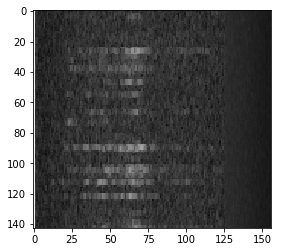

In [53]:
if GENERATE_SPECTS:
    plt.imshow(Image.fromarray(s))

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(143, 156, 3)


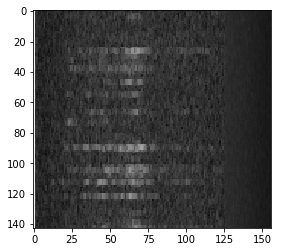

In [54]:
from scipy import misc
fname = meta.filename.values[-1]
image = misc.imread(TRAIN/fname)
print(image.shape)
plt.imshow(Image.fromarray(image))

Display image 176, which should inclue a major peak:

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


(143, 156, 3)


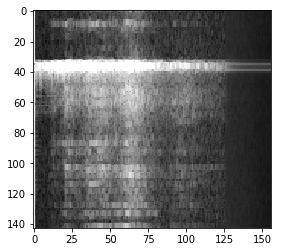

In [55]:
fname = meta.filename.values[176]
image = misc.imread(TRAIN/fname)
print(image.shape)
plt.imshow(Image.fromarray(image))